In [106]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import plotly.graph_objects as go
import scipy.io as scio
import random
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [107]:
def projectile_motion_with_resistance(state, t, g, k, m):
    x, y, v_x, v_y = state
    n = 3
    dx_dt = v_x
    dy_dt = v_y
    dv_x_dt = -(k/m) * v_x**n 
    dv_y_dt = -g - (k/m) * v_y**n
    
    return [dx_dt, dy_dt, dv_x_dt, dv_y_dt]

# 定义参数
g = 9.8  # 重力加速度
k = 0.1  # 空气阻力系数
m = 1.0  # 物体质量

# 定义初始条件
x0 = 0.0  # 初始水平位置
y0 = 10  # 初始垂直位置
v_x0 = 2.0  # 初始水平速度
v_y0 = 0  # 初始垂直速度

# 定义时间点
ts = np.linspace(0, 2, 1000)  # 从0到2秒，共取100个时间点

# 定义初始状态向量
initial_state = [x0, y0, v_x0, v_y0]

# 求解ODE方程组
solution_with_resistance = odeint(projectile_motion_with_resistance, initial_state, ts, args=(g, k, m))

# 提取位置和速度信息
x_with_resistance = solution_with_resistance[:, 0]
x_with_noise = []
for i in range(len(x_with_resistance)):
    x_with_noise.append(x_with_resistance[i] + np.random.normal(0,0.1))
y_with_resistance = solution_with_resistance[:, 1]
v_x_with_resistance = solution_with_resistance[:, 2]
v_y_with_resistance = solution_with_resistance[:, 3]

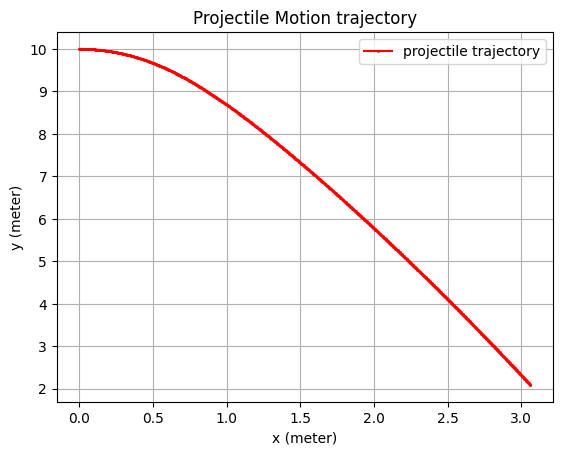

In [108]:
# 绘制轨迹
plt.plot(x_with_resistance, y_with_resistance, label = 'projectile trajectory', marker='o', markersize = 1, c = 'r')
#plt.plot(state_list[:, 0], state_list[:, 1], label = 'Kalman Filter tracking', marker='o', markersize = 3)
plt.xlabel('x (meter)')
plt.ylabel('y (meter)')
plt.title('Projectile Motion trajectory')
plt.grid(True)
plt.legend()
plt.show()

In [109]:
n_train = 800
t_train = ts[:n_train]
x_train = np.array(x_with_resistance[:n_train])
y_train = y_with_resistance[:n_train]

In [110]:
# data preparation
n_f = 10000
f_batch_size = 32

reg_in = torch.from_numpy(t_train).type(torch.float32)
reg_in = reg_in[:,None]

reg_xlabel = torch.from_numpy(x_train).type(torch.float32)
reg_xlabel = reg_xlabel[:,None]

f_x = np.random.uniform(0, 5, n_f)
f_xt = np.random.uniform(0, 2, n_f)
f_data_x = np.vstack([f_x, f_xt]).T

f_x = Variable(torch.from_numpy(f_data_x[:, 0:1]).type(torch.FloatTensor), requires_grad=True)
f_xt = Variable(torch.from_numpy(f_data_x[:, 1:2]).type(torch.FloatTensor), requires_grad=True)

f_dataset_x = torch.utils.data.TensorDataset(f_x, f_xt)
f_data_loader_x = torch.utils.data.DataLoader(f_dataset_x, batch_size = f_batch_size, shuffle=True)


In [111]:
# Define a MLP and function f
class MLP(nn.Module):
    def __init__(self, in_dim = 1,  hidden_dim = 128, out_dim = 1):

        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
                                nn.Linear(in_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, out_dim),
                                        )

    def forward(self, data_in):
        return self.mlp(data_in)

model = MLP()

class f_t(nn.Module):

    def __init__(self):

        super(f_t, self).__init__()
        self.k = nn.Parameter(1*torch.ones(1, ), requires_grad=True)

    def forward(self, t):
        u = model(t)
        u_t_x = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                                  create_graph=True, retain_graph=True)[0]
        u_tt_x = torch.autograd.grad(u_t_x, t, grad_outputs=torch.ones_like(u),
                                  create_graph=True, retain_graph=True)[0]
        return u_tt_x + (self.k)*u_t_x**3

In [112]:
# Training the PINN
n_epoch = 50
f_model = f_t()
paras = list(model.parameters()) + list(f_model.parameters())
optimizer_x = optim.Adam(paras, lr=1e-3)
Alpha_k = np.zeros(n_epoch,)

for epoch in range(n_epoch):
    for x, t in tqdm(f_data_loader_x):

        optimizer_x.zero_grad()
        pred = model(reg_in)
        reg_loss = torch.mean((reg_xlabel - pred) ** 2)
        
        f_loss = torch.mean(f_model(t) ** 2)

        loss =  reg_loss +f_loss   # adjust the coefficients between two losses
        loss.backward(retain_graph=True)
        optimizer_x.step()

    print("epoch = {}, loss = {}".format(epoch, loss))
    print("epoch = {}, f_loss = {}".format(epoch, f_loss))
    print("epoch = {}, reg_loss = {}".format(epoch, reg_loss))

    Alpha_k[epoch] = f_model.k.detach().numpy().item()


100%|██████████| 313/313 [00:01<00:00, 192.26it/s]


epoch = 0, loss = 0.11505401879549026
epoch = 0, f_loss = 0.0070081353187561035
epoch = 0, reg_loss = 0.10804588347673416


100%|██████████| 313/313 [00:01<00:00, 197.77it/s]


epoch = 1, loss = 0.09321042150259018
epoch = 1, f_loss = 0.0057350462302565575
epoch = 1, reg_loss = 0.08747537434101105


100%|██████████| 313/313 [00:01<00:00, 199.65it/s]


epoch = 2, loss = 0.048060379922389984
epoch = 2, f_loss = 0.0037568744737654924
epoch = 2, reg_loss = 0.04430350661277771


100%|██████████| 313/313 [00:01<00:00, 198.28it/s]


epoch = 3, loss = 0.013199873268604279
epoch = 3, f_loss = 0.0004532363673206419
epoch = 3, reg_loss = 0.012746636755764484


100%|██████████| 313/313 [00:01<00:00, 193.78it/s]


epoch = 4, loss = 0.0062300944700837135
epoch = 4, f_loss = 0.0028536305762827396
epoch = 4, reg_loss = 0.003376463893800974


100%|██████████| 313/313 [00:01<00:00, 201.96it/s]


epoch = 5, loss = 0.0025090158451348543
epoch = 5, f_loss = 2.203146868851036e-05
epoch = 5, reg_loss = 0.0024869844783097506


100%|██████████| 313/313 [00:01<00:00, 195.33it/s]


epoch = 6, loss = 0.0019414873095229268
epoch = 6, f_loss = 0.00011278603778919205
epoch = 6, reg_loss = 0.0018287012353539467


100%|██████████| 313/313 [00:01<00:00, 203.24it/s]


epoch = 7, loss = 0.0014232235262170434
epoch = 7, f_loss = 6.083973858039826e-05
epoch = 7, reg_loss = 0.0013623838312923908


100%|██████████| 313/313 [00:01<00:00, 200.08it/s]


epoch = 8, loss = 0.0010229370091110468
epoch = 8, f_loss = 5.590126966126263e-05
epoch = 8, reg_loss = 0.0009670357685536146


100%|██████████| 313/313 [00:01<00:00, 198.77it/s]


epoch = 9, loss = 0.0007038385956548154
epoch = 9, f_loss = 8.217208960559219e-05
epoch = 9, reg_loss = 0.000621666491497308


100%|██████████| 313/313 [00:01<00:00, 200.23it/s]


epoch = 10, loss = 0.00038349718670360744
epoch = 10, f_loss = 1.369026540487539e-05
epoch = 10, reg_loss = 0.00036980691947974265


100%|██████████| 313/313 [00:01<00:00, 197.79it/s]


epoch = 11, loss = 0.00021231079881545156
epoch = 11, f_loss = 1.5642057405784726e-05
epoch = 11, reg_loss = 0.00019666874140966684


100%|██████████| 313/313 [00:01<00:00, 186.86it/s]


epoch = 12, loss = 0.0001072353552444838
epoch = 12, f_loss = 1.0913406185864005e-05
epoch = 12, reg_loss = 9.63219499681145e-05


100%|██████████| 313/313 [00:01<00:00, 192.50it/s]


epoch = 13, loss = 0.00011246366193518043
epoch = 13, f_loss = 3.6160508898319677e-05
epoch = 13, reg_loss = 7.630314939888194e-05


100%|██████████| 313/313 [00:01<00:00, 197.11it/s]


epoch = 14, loss = 5.613408939098008e-05
epoch = 14, f_loss = 4.028134935651906e-05
epoch = 14, reg_loss = 1.585274003446102e-05


100%|██████████| 313/313 [00:01<00:00, 194.52it/s]


epoch = 15, loss = 2.4850152840372175e-05
epoch = 15, f_loss = 1.642469760554377e-05
epoch = 15, reg_loss = 8.425456144323107e-06


100%|██████████| 313/313 [00:01<00:00, 198.94it/s]


epoch = 16, loss = 2.2962778530200012e-05
epoch = 16, f_loss = 1.662688737269491e-05
epoch = 16, reg_loss = 6.3358911575051025e-06


100%|██████████| 313/313 [00:01<00:00, 202.78it/s]


epoch = 17, loss = 8.605810580775142e-05
epoch = 17, f_loss = 3.39042890118435e-05
epoch = 17, reg_loss = 5.215382043388672e-05


100%|██████████| 313/313 [00:01<00:00, 201.28it/s]


epoch = 18, loss = 0.0001943337410921231
epoch = 18, f_loss = 0.00012048680218867958
epoch = 18, reg_loss = 7.384693890344352e-05


100%|██████████| 313/313 [00:01<00:00, 193.62it/s]


epoch = 19, loss = 0.0004602315602824092
epoch = 19, f_loss = 0.0002498204994481057
epoch = 19, reg_loss = 0.00021041104628238827


100%|██████████| 313/313 [00:01<00:00, 201.79it/s]


epoch = 20, loss = 0.00022076707682572305
epoch = 20, f_loss = 0.00012459144636522979
epoch = 20, reg_loss = 9.617562318453565e-05


100%|██████████| 313/313 [00:01<00:00, 201.62it/s]


epoch = 21, loss = 6.093193405831698e-06
epoch = 21, f_loss = 6.00169232711778e-06
epoch = 21, reg_loss = 9.150104318678132e-08


100%|██████████| 313/313 [00:01<00:00, 196.07it/s]


epoch = 22, loss = 1.5689154224673985e-06
epoch = 22, f_loss = 1.1948779956583166e-06
epoch = 22, reg_loss = 3.7403745523079124e-07


100%|██████████| 313/313 [00:01<00:00, 199.18it/s]


epoch = 23, loss = 9.112536645261571e-05
epoch = 23, f_loss = 8.066385635174811e-05
epoch = 23, reg_loss = 1.0461511919857003e-05


100%|██████████| 313/313 [00:01<00:00, 202.09it/s]


epoch = 24, loss = 0.00029019732028245926
epoch = 24, f_loss = 0.00016673993377480656
epoch = 24, reg_loss = 0.0001234573865076527


100%|██████████| 313/313 [00:01<00:00, 195.34it/s]


epoch = 25, loss = 4.843784154218156e-06
epoch = 25, f_loss = 4.7950206862878986e-06
epoch = 25, reg_loss = 4.876344661397525e-08


100%|██████████| 313/313 [00:01<00:00, 201.70it/s]


epoch = 26, loss = 0.0001619864342501387
epoch = 26, f_loss = 8.093488577287644e-05
epoch = 26, reg_loss = 8.105154847726226e-05


100%|██████████| 313/313 [00:01<00:00, 201.62it/s]


epoch = 27, loss = 4.80083872389514e-05
epoch = 27, f_loss = 4.094838004675694e-05
epoch = 27, reg_loss = 7.0600085564365145e-06


100%|██████████| 313/313 [00:01<00:00, 200.68it/s]


epoch = 28, loss = 2.7229985789745115e-05
epoch = 28, f_loss = 1.0098881830344908e-05
epoch = 28, reg_loss = 1.7131103959400207e-05


100%|██████████| 313/313 [00:01<00:00, 201.78it/s]


epoch = 29, loss = 3.1823463359614834e-05
epoch = 29, f_loss = 2.473718996043317e-05
epoch = 29, reg_loss = 7.086272034939611e-06


100%|██████████| 313/313 [00:01<00:00, 202.39it/s]


epoch = 30, loss = 0.004652852192521095
epoch = 30, f_loss = 0.0029492899775505066
epoch = 30, reg_loss = 0.0017035620985552669


100%|██████████| 313/313 [00:01<00:00, 199.21it/s]


epoch = 31, loss = 1.4359659417095827e-06
epoch = 31, f_loss = 7.114871891644725e-07
epoch = 31, reg_loss = 7.244786957016913e-07


100%|██████████| 313/313 [00:01<00:00, 193.23it/s]


epoch = 32, loss = 2.12036266020732e-05
epoch = 32, f_loss = 1.924677962961141e-05
epoch = 32, reg_loss = 1.9568474272091407e-06


100%|██████████| 313/313 [00:01<00:00, 198.57it/s]


epoch = 33, loss = 8.142771548591554e-06
epoch = 33, f_loss = 1.913128471642267e-06
epoch = 33, reg_loss = 6.229643531696638e-06


100%|██████████| 313/313 [00:01<00:00, 198.67it/s]


epoch = 34, loss = 4.93567813464324e-06
epoch = 34, f_loss = 3.5754014788835775e-06
epoch = 34, reg_loss = 1.3602766557596624e-06


100%|██████████| 313/313 [00:01<00:00, 199.00it/s]


epoch = 35, loss = 5.514523763849866e-06
epoch = 35, f_loss = 4.2494725676078815e-06
epoch = 35, reg_loss = 1.2650511962419841e-06


100%|██████████| 313/313 [00:01<00:00, 195.10it/s]


epoch = 36, loss = 1.975002305698581e-05
epoch = 36, f_loss = 8.983322004496586e-06
epoch = 36, reg_loss = 1.0766701052489225e-05


100%|██████████| 313/313 [00:01<00:00, 195.44it/s]


epoch = 37, loss = 0.0008497798698954284
epoch = 37, f_loss = 0.00010801601456478238
epoch = 37, reg_loss = 0.000741763855330646


100%|██████████| 313/313 [00:01<00:00, 192.24it/s]


epoch = 38, loss = 6.634697456320282e-06
epoch = 38, f_loss = 6.477496754087042e-06
epoch = 38, reg_loss = 1.5720075907665887e-07


100%|██████████| 313/313 [00:01<00:00, 199.98it/s]


epoch = 39, loss = 8.897570296539925e-06
epoch = 39, f_loss = 2.418404392301454e-06
epoch = 39, reg_loss = 6.479165676864795e-06


100%|██████████| 313/313 [00:01<00:00, 197.41it/s]


epoch = 40, loss = 3.2890216971281916e-05
epoch = 40, f_loss = 2.09386671485845e-05
epoch = 40, reg_loss = 1.1951548913202714e-05


100%|██████████| 313/313 [00:01<00:00, 201.35it/s]


epoch = 41, loss = 3.435731969148037e-06
epoch = 41, f_loss = 2.9700597679038765e-06
epoch = 41, reg_loss = 4.6567211597903224e-07


100%|██████████| 313/313 [00:01<00:00, 201.26it/s]


epoch = 42, loss = 6.664484317298047e-06
epoch = 42, f_loss = 3.027907951036468e-06
epoch = 42, reg_loss = 3.6365765936352545e-06


100%|██████████| 313/313 [00:01<00:00, 197.77it/s]


epoch = 43, loss = 4.025573616672773e-06
epoch = 43, f_loss = 4.356741101219086e-07
epoch = 43, reg_loss = 3.589899279177189e-06


100%|██████████| 313/313 [00:01<00:00, 194.38it/s]


epoch = 44, loss = 2.776021938188933e-05
epoch = 44, f_loss = 2.0922714611515403e-05
epoch = 44, reg_loss = 6.837504315626575e-06


100%|██████████| 313/313 [00:01<00:00, 201.83it/s]


epoch = 45, loss = 1.6903295545489527e-05
epoch = 45, f_loss = 1.314268956775777e-05
epoch = 45, reg_loss = 3.7606064324791078e-06


100%|██████████| 313/313 [00:01<00:00, 197.55it/s]


epoch = 46, loss = 1.6666021110722795e-05
epoch = 46, f_loss = 7.871446541685145e-06
epoch = 46, reg_loss = 8.79457456903765e-06


100%|██████████| 313/313 [00:01<00:00, 200.15it/s]


epoch = 47, loss = 0.0005231290124356747
epoch = 47, f_loss = 0.00022386998170986772
epoch = 47, reg_loss = 0.00029925903072580695


100%|██████████| 313/313 [00:01<00:00, 201.16it/s]


epoch = 48, loss = 0.00018276984337717295
epoch = 48, f_loss = 0.00016482017235830426
epoch = 48, reg_loss = 1.79496782948263e-05


100%|██████████| 313/313 [00:01<00:00, 200.59it/s]

epoch = 49, loss = 2.9963114229758503e-06
epoch = 49, f_loss = 1.0586247753963107e-06
epoch = 49, reg_loss = 1.9376866475795396e-06


In [113]:
# Train a pure MLP in x direction
model_mlp = MLP()
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3)
for epoch in range(1000):

        optimizer_mlp.zero_grad()
        pred = model_mlp(reg_in)
        mlp_loss = torch.mean((reg_xlabel - pred) ** 2)
        mlp_loss.backward()
        optimizer_mlp.step()
        print("epoch = {}, loss = {}".format(epoch, mlp_loss))

epoch = 0, loss = 2.172760486602783
epoch = 1, loss = 1.303315281867981
epoch = 2, loss = 0.710885226726532
epoch = 3, loss = 0.3827747106552124
epoch = 4, loss = 0.29349765181541443
epoch = 5, loss = 0.3634660243988037
epoch = 6, loss = 0.45066970586776733
epoch = 7, loss = 0.4574540853500366
epoch = 8, loss = 0.3812125027179718
epoch = 9, loss = 0.2663569748401642
epoch = 10, loss = 0.16181910037994385
epoch = 11, loss = 0.10085481405258179
epoch = 12, loss = 0.09177088737487793
epoch = 13, loss = 0.1164204478263855
epoch = 14, loss = 0.14159779250621796
epoch = 15, loss = 0.14153556525707245
epoch = 16, loss = 0.11201077699661255
epoch = 17, loss = 0.06696619838476181
epoch = 18, loss = 0.02697118930518627
epoch = 19, loss = 0.007961838506162167
epoch = 20, loss = 0.0138707235455513
epoch = 21, loss = 0.035589706152677536
epoch = 22, loss = 0.057298917323350906
epoch = 23, loss = 0.06648337841033936
epoch = 24, loss = 0.060392264276742935
epoch = 25, loss = 0.04526514932513237
epoch

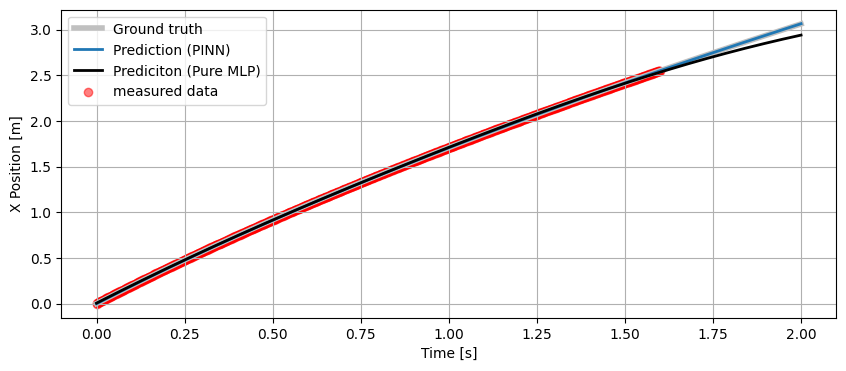

In [114]:
# Time series

ts_torch = torch.from_numpy(ts).type(torch.float32)
ts_torch = ts_torch[:,None]

plt.figure(figsize=(10, 4))
plt.plot(ts, x_with_resistance,color = "silver", lw = 4)
plt.plot(ts, model( ts_torch )[:,0:1].detach().numpy(),lw = 2)
plt.plot(ts, model_mlp( ts_torch )[:,0:1].detach().numpy(), color = "black", lw = 2)
plt.scatter(t_train, x_train,alpha=0.5, c = "red")
plt.xlabel('Time [s]')
plt.ylabel('X Position [m]')
plt.legend(['Ground truth', 'Prediction (PINN)', "Prediciton (Pure MLP)","measured data"])
plt.grid(True)

Parameter containing:
tensor([0.0984], requires_grad=True)


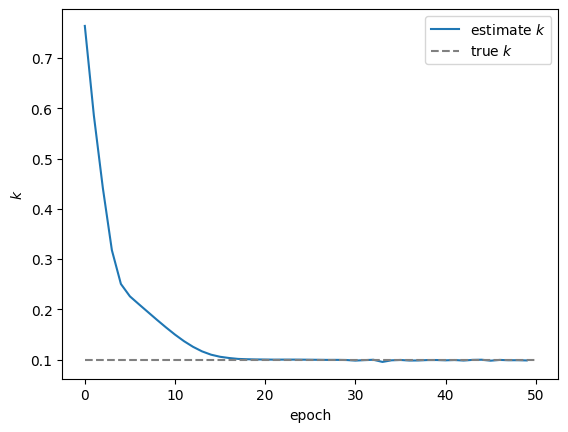

In [115]:
print(f_model.k)

plt.plot(np.asarray(Alpha_k), label = r"estimate $k$")
plt.plot(np.linspace(0,n_epoch, n_epoch), k*np.ones(n_epoch),"--", color = "gray", label = r"true $k$")
plt.ylabel(r"$k$")
plt.xlabel("epoch")
plt.legend()